1. Import all Libraries

In [ ]:
import re
from pathlib import Path
from tqdm import tqdm
from llama_index.core import Document  # Ensure correct version installed
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import normalize
import pickle
import time
import chromadb
from chromadb.config import Settings
import shutil
import os
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from rank_bm25 import BM25Okapi

/Users/fatemehshahlaei/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


2. Diversity-Based Chunking Algorithm Analysis (Optimal way to calculate chunk size)

60it [00:16,  3.59it/s]


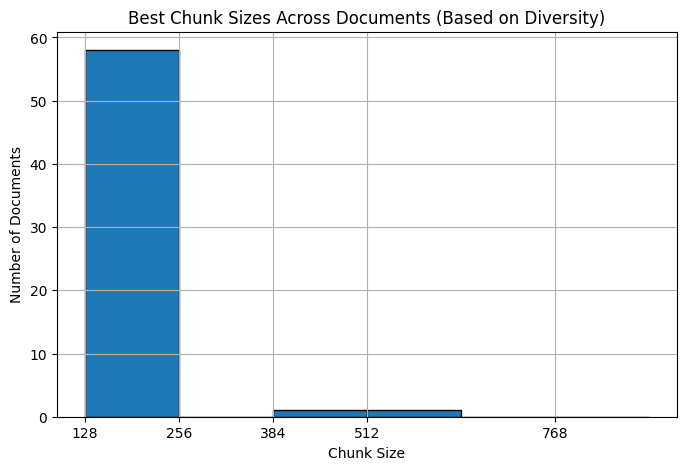

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations

from sentence_transformers import SentenceTransformer, util
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load SBERT
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Step 1: Text Cleaning
def preprocess_text(text):
    text = re.sub(r'[^\w\s.,;:!?\-()\[\]\'"]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Chunking
def chunk_text(text, chunk_size, overlap):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    return splitter.create_documents([text])

# Step 3: Diversity Score (Average pairwise distance)
def compute_diversity_score(chunks):
    if len(chunks) < 2:
        return 0

    texts = [c.page_content for c in chunks]
    embeddings = model.encode(texts, convert_to_tensor=True)
    sim_matrix = util.cos_sim(embeddings, embeddings)
    
    # Remove self-similarity and compute average of upper triangle
    total_sim = 0
    count = 0
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            total_sim += sim_matrix[i][j].item()
            count += 1
    avg_sim = total_sim / count if count else 0
    return 1 - avg_sim  # higher = more diverse

# Step 4: Run on all documents
def find_best_chunk_sizes(data_dir, chunk_sizes=[128, 256, 384, 512, 768], overlap=50):
    best_sizes = []

    for file_path in tqdm(Path(data_dir).glob("*.txt")):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        cleaned_text = preprocess_text(text)
        best_score = -1
        best_size = 0

        for cs in chunk_sizes:
            chunks = chunk_text(cleaned_text, cs, overlap)
            if not chunks:
                continue

            score = compute_diversity_score(chunks)

            if score > best_score:
                best_score = score
                best_size = cs

        best_sizes.append(best_size)

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(best_sizes, bins=range(min(chunk_sizes), max(chunk_sizes) + 150, 128), edgecolor='black')
    plt.title("Best Chunk Sizes Across Documents (Based on Diversity)")
    plt.xlabel("Chunk Size")
    plt.ylabel("Number of Documents")
    plt.xticks(chunk_sizes)
    plt.grid(True)
    plt.show()

    return best_sizes

data_dir = "ancient_greece_data"
best_sizes = find_best_chunk_sizes(data_dir)

3. Apply Chunking Technique with Optimal Chunk: 

In [3]:
def preprocess_text(text):
    """Clean and normalize text"""
    text = re.sub(r'[^\w\s.,;:!?\-()\[\]\'"]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_chunk_documents(data_dir, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    
    all_chunks = []
    for file_path in tqdm(Path(data_dir).glob("*.txt")):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        cleaned_text = preprocess_text(text)

        chunks = text_splitter.create_documents(
            texts=[cleaned_text],
            metadatas=[{
                "file_name": file_path.name,
                "file_path": str(file_path),
                "chunk_id": f"{file_path.stem}_"
            }]
        )
        
        # Add chunk ID
        for i, chunk in enumerate(chunks):
            chunk.metadata["chunk_id"] += str(i)
            all_chunks.append(chunk)

    print(f"\n Total Chunks: {len(all_chunks)}")
    return all_chunks


In [4]:
documents = load_and_chunk_documents("ancient_greece_data", chunk_size=256, chunk_overlap=50)

60it [00:00, 2323.86it/s]


 Total Chunks: 516


4. Apply Embedding Technique using SBERT

In [5]:
# 1. choose model
model = SentenceTransformer('all-MiniLM-L6-v2')  

# 2. Extract content from chunks
print("Preparing chunks for embedding...")
for i in range(3):
    print(f"Doc {i} chunk_id: {documents[i].metadata.get('chunk_id')}")

# Generate embeddings
chunk_contents = [doc.page_content for doc in documents]
chunk_embeddings = model.encode(
    chunk_contents,
    batch_size=4,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

# Apply embeddings on each chunk
for i, doc in enumerate(documents):
    doc.metadata['embedding'] = chunk_embeddings[i]

#  check structure of embedding
print("\n Checking metadata AFTER embedding:")
for i in range(3):
    print(f"Doc {i} chunk_id: {documents[i].metadata.get('chunk_id')}")



Preparing chunks for embedding...
Doc 0 chunk_id: 1_0
Doc 1 chunk_id: 1_1
Doc 2 chunk_id: 1_2


Batches:   0%|          | 0/129 [00:00<?, ?it/s]


 Checking metadata AFTER embedding:
Doc 0 chunk_id: 1_0
Doc 1 chunk_id: 1_1
Doc 2 chunk_id: 1_2


5. Store the Embedding Vectors in a Vector Database (ChromaDB)

5. a. Clean the Database Before Storing Embedding Vectors

In [6]:
client = chromadb.Client(Settings(
    persist_directory="./my_new_chroma_db",
    anonymized_telemetry=False
))

collection = client.get_or_create_collection(
    name="document_chunks",
    metadata={"hnsw:space": "cosine"}
)



 5. b. Store Embedding Vectors in the Database 

In [7]:
batch_size = 100
total_chunks = len(documents)

print(f"Uploading {total_chunks} chunks in batches of {batch_size}")

for i in tqdm(range(0, total_chunks, batch_size), desc="Uploading"):
    batch = documents[i:i + batch_size]

    ids = [doc.metadata["chunk_id"] for doc in batch]
    embeddings = [doc.metadata["embedding"].tolist() for doc in batch]
    
    metadatas = [{
        "file_name": doc.metadata["file_name"],
        "file_path": doc.metadata["file_path"],
        "chunk_id": doc.metadata.get("chunk_id", "UNKNOWN"),
        "text": doc.page_content[:50000]
    } for doc in batch]

    documents_list = [doc.page_content for doc in batch]

    collection.upsert(
        ids=ids,
        embeddings=embeddings,
        metadatas=metadatas,
        documents=documents_list
    )

print(f"\n Success! Uploaded {collection.count()} chunks.")


Uploading 516 chunks in batches of 100


Uploading: 100%|██████████| 6/6 [00:00<00:00, 20.25it/s]


 Success! Uploaded 516 chunks.


In [1]:
# =====================================
# 5c. SAVE EMBEDDING VECTORS TO LOCAL FILE
# =====================================

import pickle

all_data = []

for doc in documents:
    all_data.append({
        "id": doc.metadata["chunk_id"],
        "embedding": doc.metadata["embedding"].tolist(),   # must be list
        "metadata": {
            "file_name": doc.metadata["file_name"],
            "file_path": doc.metadata["file_path"],
            "chunk_id": doc.metadata.get("chunk_id", "UNKNOWN"),
            "text": doc.page_content[:50000]              # keep text short
        },
        "document": doc.page_content
    })

# 💾 Save to local .pkl file
with open("embedded_chunks_safe.pkl", "wb") as f:
    pickle.dump(all_data, f)

print("✅ Embeddings saved to 'embedded_chunks_safe.pkl'")


NameError: name 'documents' is not defined

In [ ]:
# =====================================
# 5d. LOAD EMBEDDINGS BACK FOR TESTING
# =====================================

import pickle

with open("embedded_chunks_safe.pkl", "rb") as f:
    local_embedded_docs = pickle.load(f)

print(f"✅ Loaded {len(local_embedded_docs)} embedded chunks.")


6.  Pipeline to Retrieve Top-K Relevant Documents using Hybrid Search and Re-ranking Technique By Calling Embedding Vectors From Chroma DB:

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
# Load embedding and cross-encoder models
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Get documents and metadata from Chroma collection
res = collection.get(include=["documents", "metadatas"])

# Flatten it
docs_flat = sum(res["documents"], []) if isinstance(res["documents"][0], list) else res["documents"]
metas_flat = sum(res["metadatas"], []) if isinstance(res["metadatas"][0], list) else res["metadatas"]

# Build corpus
corpus = [
    {"text": doc, "metadata": meta}
    for doc, meta in zip(docs_flat, metas_flat)
]

# Pre-tokenize corpus for BM25
tokenized_corpus = [doc["text"].split() for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

# Hybrid search function
def hybrid_search(query, top_k=5, similarity_threshold=0.5):
    # Step 1: Vector search
    query_embedding = embedding_model.encode(query, normalize_embeddings=True)
    vector_results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=top_k * 3,
        include=["documents", "metadatas", "distances"]
    )

    vector_hits = [
        {"text": doc, "metadata": meta}
        for doc, meta in zip(vector_results["documents"][0], vector_results["metadatas"][0])
    ]

    # Step 2: keyword search: BM25
    bm25_scores = bm25.get_scores(query.split())
    top_bm25_indices = sorted(range(len(bm25_scores)), key=lambda i: bm25_scores[i], reverse=True)[:top_k * 3]
    bm25_hits = [{"text": corpus[i]["text"], "metadata": corpus[i]["metadata"]} for i in top_bm25_indices]
    # Step 4: Merge results
    combined_docs = {doc["text"]: doc for doc in vector_hits + bm25_hits}
    combined_list = list(combined_docs.values())
    # Step 5: Semantic similarity filter (instead of exact string match)
    query_emb = embedding_model .encode([query])
    doc_embs = embedding_model.encode([doc["text"] for doc in combined_list])
    sims = cosine_similarity(query_emb, doc_embs)[0]
    # Keep only documents with similarity above threshold value
    filtered_docs = [
        doc for doc, sim in zip(combined_list, sims)
        if sim > similarity_threshold
    ]

    if not filtered_docs:
        print(" No relevant document found for the query.")
        return []

    # Step 6: Re-rank
    cross_inp = [(query, doc["text"]) for doc in filtered_docs]
    scores = cross_encoder.predict(cross_inp)
    reranked = sorted(zip(scores, filtered_docs), key=lambda x: x[0], reverse=True)

    return [doc for _, doc in reranked[:top_k]]





7. Ollama Model with Prompt Template

In [9]:
! pip install pydantic==1.10.13
! pip install ollama
!pip show ollama

  Using cached pydantic-1.10.13-cp311-cp311-win_amd64.whl.metadata (150 kB)
Using cached pydantic-1.10.13-cp311-cp311-win_amd64.whl (2.1 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.7
    Uninstalling pydantic-2.11.7:
      Successfully uninstalled pydantic-2.11.7


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.2.1 requires langchain-core!=0.3.0,!=0.3.1,!=0.3.10,!=0.3.11,!=0.3.12,!=0.3.13,!=0.3.14,!=0.3.2,!=0.3.3,!=0.3.4,!=0.3.5,!=0.3.6,!=0.3.7,!=0.3.8,!=0.3.9,<0.4.0,>=0.2.43, but you have langchain-core 0.1.23 which is incompatible.
langchain-experimental 0.3.3 requires langchain-community<0.4.0,>=0.3.0, but you have langchain-community 0.0.20 which is incompatible.
langchain-experimental 0.3.3 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 0.1.23 which is incompatible.
langchain-google-genai 2.0.9 requires langchain-core<0.4.0,>=0.3.27, but you have langchain-core 0.1.23 which is incompatible.
langchain-google-genai 2.0.9 requires pydantic<3,>=2, but you have pydantic 1.10.13 which is incompatible.
langchain-huggingface 0.1.2 requires langchain-core<0.4.0,>=0.3.15, but you have l

  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.13
    Uninstalling pydantic-1.10.13:
      Successfully uninstalled pydantic-1.10.13


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-chroma 0.2.1 requires langchain-core!=0.3.0,!=0.3.1,!=0.3.10,!=0.3.11,!=0.3.12,!=0.3.13,!=0.3.14,!=0.3.2,!=0.3.3,!=0.3.4,!=0.3.5,!=0.3.6,!=0.3.7,!=0.3.8,!=0.3.9,<0.4.0,>=0.2.43, but you have langchain-core 0.1.23 which is incompatible.
langchain-experimental 0.3.3 requires langchain-community<0.4.0,>=0.3.0, but you have langchain-community 0.0.20 which is incompatible.
langchain-experimental 0.3.3 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 0.1.23 which is incompatible.
langchain-google-genai 2.0.9 requires langchain-core<0.4.0,>=0.3.27, but you have langchain-core 0.1.23 which is incompatible.
langchain-huggingface 0.1.2 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 0.1.23 which is incompatible.
langchain-openai 0.2.12 requires langchain-core<0.4.0,>=0.3.21,

Name: ollama
Version: 0.4.7
Summary: The official Python client for Ollama.
Home-page: https://ollama.com
Author: Ollama
Author-email: hello@ollama.com
License: MIT
Location: C:\Users\niraj\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: httpx, pydantic
Required-by: 


In [10]:
import ollama

def format_prompt(query, retrieved_docs):
    """Create a prompt template"""
    context_blocks = []
    sources_used = set()  # Track which sources are provided
    
    for i, doc in enumerate(retrieved_docs):
        # Extract clean source identifier
        file_name = doc['metadata'].get('file_name', 'unknown_source')
        source_id = file_name.replace('.txt', '')  #
        
        # Format context block with source id
        context_block = f"[[SOURCE: {source_id}]]\n{doc['text'][:1000]}\n"
        context_blocks.append(context_block)
        sources_used.add(source_id)
    
    context = "\n".join(context_blocks)
    
    prompt = f"""## Instruction
You are a helpful assistant. Answer the question using ONLY the following context.
You MUST cite sources using [[SOURCE: name]] format for EVERY factual claim.
If the answer is not present, respond: "I don't have enough information to answer this question."

## Available Sources
{', '.join(sources_used)}

## Context
{context}

## Question
{query}

## Answer (with citations):"""
    return prompt

def generate_answer(query, retrieved_docs, model_name="llama3.2:1b"):
    """Generate answer with proper source attribution"""
    prompt = format_prompt(query, retrieved_docs)
    
    response = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "system", 
                "content": "You must cite sources for all factual information using [[SOURCE: name]] format."
            },
            {"role": "user", "content": prompt}
        ],
        options={
            "temperature": 0.1,  # More deterministic output
            "num_ctx": 512  # smallercontext window
        }
    )
    
    return response['message']['content'].strip()

def extract_citations(answer):
    """Helper to parse and format citations"""
    import re
    sources = set(re.findall(r'\[\[SOURCE: (.*?)\]\]', answer))
    if sources:
        return f"\n Sources: {', '.join(f'[{src}]' for src in sources)}"
    return ""



8. LLM Response

In [11]:
query = "What purpose did the tales of ancient Greek heroes serve beyond entertainment?"
retrieved_docs = hybrid_search(query)  
answer = generate_answer(query, retrieved_docs)
print("Query:", query)
print("\n LLM response:")
print(answer)
print(extract_citations(answer))
print("\n Retrieved Documents:")

for i, doc in enumerate(retrieved_docs[:3]):  # Show top 3 sources
    source = doc['metadata'].get('file_name', 'unknown')
    print(f"\n• [{source.replace('.txt', '')}]:")
    print(f"  {doc['text'][:200]}...")

Query: What purpose did the tales of ancient Greek heroes serve beyond entertainment?

 LLM response:
I don't have enough information to answer this question.

The provided context does not mention the purpose served by the tales of ancient Greek heroes beyond entertainment. In fact, it only mentions that they "entertained with their tales" and were important cultural symbols, but it does not elaborate on other possible purposes they may have served.


 Retrieved Documents:

• [8]:
  . These legendary heroes of ancient Greece not only entertained with their tales but also served as important cultural symbols. They embodied qualities that were highly valued in Greek society, such a...

• [9]:
  The tales of these heroes also served as a means of explaining natural phenomena and human experiences. For example, Heracles's Twelve Labors could be seen as symbolic representations of the challenge...

• [7]:
  The Legendary Heroes of Ancient Greece Ancient Greece is known for its rich mytholo

# Evaluation of the model

1. Calculate Model Metrices to Evaluate LLM Response: 

In [12]:
import nltk
nltk.download('punkt')
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import sent_tokenize, word_tokenize

def evaluate_rouge_bleu(answer, contexts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothing = SmoothingFunction().method4

    all_context = " ".join(contexts).lower()
    sentences = sent_tokenize(answer)

    results = []

    for i, sent in enumerate(sentences):
        sent_clean = sent.strip()
        rouge = scorer.score(sent_clean, all_context)
        bleu = sentence_bleu(
            [word_tokenize(all_context)],
            word_tokenize(sent_clean),
            smoothing_function=smoothing
        )

        results.append({
            "sentence": sent_clean,
            "rouge1": rouge["rouge1"].fmeasure,
            "rouge2": rouge["rouge2"].fmeasure,
            "rougeL": rouge["rougeL"].fmeasure,
            "bleu": bleu
        })

    return results

scores = evaluate_rouge_bleu(answer, [doc["text"] for doc in retrieved_docs])

for s in scores:
    print(f"\n Sentence: {s['sentence']}")
    print(f"  ROUGE-1: {s['rouge1']:.3f}")
    print(f"  ROUGE-2: {s['rouge2']:.3f}")
    print(f"  ROUGE-L: {s['rougeL']:.3f}")
    print(f"  BLEU   : {s['bleu']:.3f}")



 Sentence: I don't have enough information to answer this question.
  ROUGE-1: 0.023
  ROUGE-2: 0.000
  ROUGE-L: 0.023
  BLEU   : 0.000

 Sentence: The provided context does not mention the purpose served by the tales of ancient Greek heroes beyond entertainment.
  ROUGE-1: 0.133
  ROUGE-2: 0.034
  ROUGE-L: 0.099
  BLEU   : 0.000

 Sentence: In fact, it only mentions that they "entertained with their tales" and were important cultural symbols, but it does not elaborate on other possible purposes they may have served.
  ROUGE-1: 0.188
  ROUGE-2: 0.053
  ROUGE-L: 0.104
  BLEU   : 0.002


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Evaluate of Retrival System

1. Similarity score

In [13]:
from sentence_transformers import SentenceTransformer, util

# 1. Load sentence embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def score_similarity(query, docs):
    query_embedding = model.encode(query, convert_to_tensor=True)
    doc_embeddings = model.encode(docs, convert_to_tensor=True)
    scores = util.cos_sim(query_embedding, doc_embeddings)
    return scores.squeeze().tolist()

# 5. Get scores
doc_texts = [doc['text'] for doc in retrieved_docs]
scores = score_similarity(query, doc_texts)

# 6. Pair each document with its score and sort by score descending
ranked = sorted(zip(retrieved_docs, scores), key=lambda x: x[1], reverse=True)

# 7. Display ranked results
for i, (doc, score) in enumerate(ranked, 1):
    print(f"[{i}] Score: {score:.4f}")
    print(f"    Source: {doc['metadata'].get('file_name', 'N/A')}")
    print(f"    Excerpt: {doc['text'][:150]}...\n")

[1] Score: 0.7156
    Source: 8.txt
    Excerpt: . These legendary heroes of ancient Greece not only entertained with their tales but also served as important cultural symbols. They embodied qualitie...

[2] Score: 0.6318
    Source: 8.txt
    Excerpt: . The stories of these heroes were often used as cautionary tales or as examples of virtue to inspire and guide individuals...

[3] Score: 0.5978
    Source: 7.txt
    Excerpt: The Legendary Heroes of Ancient Greece Ancient Greece is known for its rich mythology and fascinating stories of heroes. These legendary figures have ...

[4] Score: 0.5771
    Source: 9.txt
    Excerpt: . In conclusion, the legendary heroes of ancient Greece, such as Heracles, Theseus, and Perseus, have left an indelible mark on Greek culture and cont...

[5] Score: 0.5461
    Source: 9.txt
    Excerpt: The tales of these heroes also served as a means of explaining natural phenomena and human experiences. For example, Heracles's Twelve Labors could be...



2. Keyword Coverage Scores

In [14]:
import re

def score_keyword_coverage(query, docs):
    """
    Measures how well retrieved documents cover important query terms
    Returns scores from 0-1 for each document
    """
    # Remove stop words from query
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'what', 'how', 'why', 'when', 'where'}
    query_words = set(re.findall(r'\b\w+\b', query.lower())) - stop_words
    
    if not query_words:
        return [0.0] * len(docs)
    
    scores = []
    for doc in docs:
        doc_words = set(re.findall(r'\b\w+\b', doc.lower()))
        matched_words = query_words.intersection(doc_words)
        coverage_score = len(matched_words) / len(query_words)
        scores.append(coverage_score)
    
    return scores


# Get keyword coverage scores
doc_texts = [doc['text'] for doc in retrieved_docs]
coverage_scores = score_keyword_coverage(query, doc_texts)

# Pair each document with its coverage score and sort by score descending
ranked_coverage = sorted(zip(retrieved_docs, coverage_scores), key=lambda x: x[1], reverse=True)

# Display ranked results
print(" KEYWORD COVERAGE EVALUATION:")
for i, (doc, score) in enumerate(ranked_coverage, 1):
    print(f"[{i}] Coverage Score: {score:.4f}")
    print(f"    Source: {doc['metadata'].get('file_name', 'N/A')}")
    print(f"    Excerpt: {doc['text'][:150]}...\n")

 KEYWORD COVERAGE EVALUATION:
[1] Coverage Score: 0.4444
    Source: 8.txt
    Excerpt: . These legendary heroes of ancient Greece not only entertained with their tales but also served as important cultural symbols. They embodied qualitie...

[2] Coverage Score: 0.3333
    Source: 7.txt
    Excerpt: The Legendary Heroes of Ancient Greece Ancient Greece is known for its rich mythology and fascinating stories of heroes. These legendary figures have ...

[3] Coverage Score: 0.3333
    Source: 9.txt
    Excerpt: . In conclusion, the legendary heroes of ancient Greece, such as Heracles, Theseus, and Perseus, have left an indelible mark on Greek culture and cont...

[4] Coverage Score: 0.2222
    Source: 9.txt
    Excerpt: The tales of these heroes also served as a means of explaining natural phenomena and human experiences. For example, Heracles's Twelve Labors could be...

[5] Coverage Score: 0.2222
    Source: 8.txt
    Excerpt: . The stories of these heroes were often used as cautionary 

3. Content Density Scores

In [15]:
import re

def score_content_density(query, docs):
    """
    Measures information density - how much relevant content per document length
    Combines keyword frequency with document length normalization
    """
    # Extract query keywords (remove stop words)
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'what', 'how', 'why', 'when', 'where'}
    query_words = [word.lower() for word in re.findall(r'\b\w+\b', query) if word.lower() not in stop_words]
    
    if not query_words:
        return [0.0] * len(docs)
    
    scores = []
    for doc in docs:
        doc_lower = doc.lower()
        doc_words = doc.split()
        
        # Count query word occurrences in document
        keyword_count = 0
        for query_word in query_words:
            keyword_count += doc_lower.count(query_word)
        
        # Calculate density: keyword_frequency / document_length  
        # Add small constant to avoid division by zero
        density_score = keyword_count / (len(doc_words) + 1)
        
        # Normalize to 0-1 range (multiply by 100 for better scale)
        normalized_score = min(density_score * 100, 1.0)
        scores.append(normalized_score)
    
    return scores


# Get content density scores
doc_texts = [doc['text'] for doc in retrieved_docs]
density_scores = score_content_density(query, doc_texts)

# Pair each document with its density score and sort by score descending
ranked_density = sorted(zip(retrieved_docs, density_scores), key=lambda x: x[1], reverse=True)

# Display ranked results
print(" CONTENT DENSITY EVALUATION:")
for i, (doc, score) in enumerate(ranked_density, 1):
    print(f"[{i}] Density Score: {score:.4f}")
    print(f"    Source: {doc['metadata'].get('file_name', 'N/A')}")
    print(f"    Excerpt: {doc['text'][:150]}...\n")

 CONTENT DENSITY EVALUATION:
[1] Density Score: 1.0000
    Source: 8.txt
    Excerpt: . These legendary heroes of ancient Greece not only entertained with their tales but also served as important cultural symbols. They embodied qualitie...

[2] Density Score: 1.0000
    Source: 9.txt
    Excerpt: The tales of these heroes also served as a means of explaining natural phenomena and human experiences. For example, Heracles's Twelve Labors could be...

[3] Density Score: 1.0000
    Source: 7.txt
    Excerpt: The Legendary Heroes of Ancient Greece Ancient Greece is known for its rich mythology and fascinating stories of heroes. These legendary figures have ...

[4] Density Score: 1.0000
    Source: 9.txt
    Excerpt: . In conclusion, the legendary heroes of ancient Greece, such as Heracles, Theseus, and Perseus, have left an indelible mark on Greek culture and cont...

[5] Density Score: 1.0000
    Source: 8.txt
    Excerpt: . The stories of these heroes were often used as cautionary tales 